In [1]:
from scapy.all import *
conf.use_pcap = True
from datetime import datetime

import pandas as pd

import matplotlib

font = {'family' : 'normal',
        'size'   : 25}

matplotlib.rc('font', **font,)
matplotlib.rc('text',  usetex=True)
matplotlib.rc('xtick', labelsize=25) 
matplotlib.rc('ytick', labelsize=25) 

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

In [2]:
TS_START=480
TS_END=500

OFFSET_TIME=None

In [3]:
packets = rdpcap('test90-cmp.pcap')

In [4]:
delta_mac=[]
delta_os=[]

for i in range(0,len(packets)-1):
    packet = packets[i]
    am=float(str(packet[RadioTap].mac_timestamp))
    at=float(str(packet.time))
    
    packet = packets[i+1]
    bm=float(str(packet[RadioTap].mac_timestamp))
    bt=float(str(packet.time))
    
    dm=(bm-am)/1000.0
    dt=(bt-at)*1000.0
    delta_mac.append(dm)
    delta_os.append(dt)

df_mac=pd.DataFrame(delta_mac)
df_os=pd.DataFrame(delta_os)

In [5]:
first=None
floor=-92

SKIP=1
c=0

rf=pd.DataFrame(data={"time":[],"power":[]})
rf=rf.set_index("time",drop=True)
for packet in packets:
    if c<SKIP:
        c+=1
        continue
    rssi=packet[RadioTap].dBm_AntSignal
    rate=packet[RadioTap].Rate
    ts=float(str(packet.time))
    l=packet.wirelen
    if l>1028:
        packet.show()
    preamble=0.000192
    
    if first==None:
        first=ts
        
    start=(ts-first)*1000.0
    duration=(preamble+l*8.0/(rate*1000000/2))*1000.0
    rf.loc[start-1]=floor
    rf.loc[start-preamble]=rssi
    rf.loc[start+duration]=floor

In [6]:
df=pd.read_csv("rssi-1585214548.csv",parse_dates=["time"],index_col=0)

In [7]:
from enum import Enum
    
class Chanspec:
    WL_CHANSPEC_CHAN_MASK=0x00ff

    WL_CHANSPEC_BW_MASK=0x3800
    class Bandwidth(Enum):
        WL_CHANSPEC_BW_5=0x0000
        WL_CHANSPEC_BW_10=0x0800
        WL_CHANSPEC_BW_20=0x1000
        WL_CHANSPEC_BW_40=0x1800
        WL_CHANSPEC_BW_80=0x2000
        WL_CHANSPEC_BW_160=0x2800
        WL_CHANSPEC_BW_8080=0x3000
    
    WL_CHANSPEC_BAND_MASK=0xc000
    class Band(Enum):
        WL_CHANSPEC_BAND_2G=0x0000
        WL_CHANSPEC_BAND_3G=0x4000
        WL_CHANSPEC_BAND_4G=0x8000
        WL_CHANSPEC_BAND_5G=0xc000
        
    def __init__(self,chanspec):
        self.channel=chanspec&self.WL_CHANSPEC_CHAN_MASK
        self.bandwidth=self.Bandwidth(chanspec&self.WL_CHANSPEC_BW_MASK)
        self.band=self.Band(chanspec&self.WL_CHANSPEC_BAND_MASK)
        
    def __repr__(self):
        return "Channel: %d, Bandwidth %s, Band %s"%(self.channel,self.bandwidth.name,self.band.name)

WL_CHANSPEC_BAND_SHIFT=14

chanspec=Chanspec(df.iloc[0].chanspec)
print(chanspec)

Channel: 13, Bandwidth WL_CHANSPEC_BW_20, Band WL_CHANSPEC_BAND_2G


In [8]:
nf=df.copy()
nf["power"]=(df["power"]/8.0)-92.0

In [9]:
CCA=-85
OFFSET=51012

zf=nf
zf=nf.copy(deep=True)
dt_first = datetime.fromtimestamp(first-60*60)
zf["time"]-=dt_first
zf["time"]=zf["time"].dt.total_seconds()*1e3
zf=zf.set_index("time",drop=True)
zf=zf[TS_START:TS_END]

mf=zf.copy(deep=True)
MAX_VAL=zf["power"].max()
MIN_VAL=zf["power"].min()
pf=mf.power.copy(deep=True)
pf[pf > CCA]=MAX_VAL
pf[pf <= CCA]=MIN_VAL
mf["power"]=pf

(485.0, 497.0)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


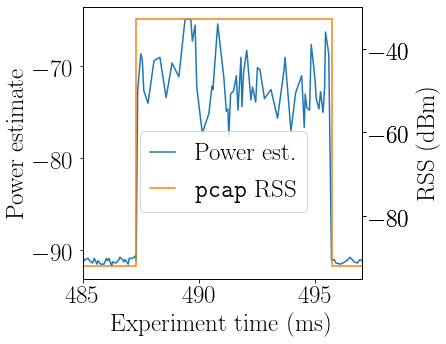

In [10]:
zrf=rf[TS_START:TS_END]

pzf=pd.DataFrame()
pzf["Power est."]=zf["power"]
ax=pzf["Power est."].plot(figsize=[5,5],legend=False)
ax.set_ylabel("Power estimate")

pzrf=pd.DataFrame()
pzrf["\\texttt{pcap} RSS"]=zrf["power"]
ax2=pzrf["\\texttt{pcap} RSS"].plot(ax=ax,secondary_y=True,drawstyle="steps-post",figsize=[5,5],legend=False)
ax.set_xlabel("Experiment time (ms)")

axy = ax2.secondary_yaxis('right')
axy.set_ylabel("RSS (dBm)")

f=plt.gcf()
f.legend(["Power est.","\\texttt{pcap} RSS"],loc="center",handlelength=1)
ax.set_xlim(485,497)